# Predicting Flight Delays: Regression Models

In [569]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [570]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [723]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
import xgboost as xgb

In [674]:
flights = pd.read_csv('../data/data-feature/flights-feature-edit.csv')

In [675]:
flights.rename(columns={'fl_date': 'date'}, inplace=True)

In [676]:
flights.shape

(980258, 41)

In [677]:
weather = pd.read_csv('../data/data-feature/flights_weather_feature_engineering.csv')

In [678]:
weather.drop('Unnamed: 0', axis=1, inplace=True)

In [679]:
weather.head()

,date,origin,dest,dep_delay,arr_delay,dep_avg_temp,dep_precip_mm,dep_humidity,dep_visibility,dep_total_snowcm,...,arr_snow,arr_rainy,arr_snow_bin,dep_snow_bin,arr_precip_bin,dep_precip_bin,dep_humidity_bin,arr_humidity_bin,dep_avgtemp_bin,arr_avgtemp_bin
0,2018-06-21,DFW,LGA,2.0,-8.0,26,0.0,52,10,0.0,...,0,0,0,0,0,0,2,2,3,3
1,2018-06-21,DFW,LGA,159.0,162.0,26,0.0,52,10,0.0,...,0,0,0,0,0,0,2,2,3,3
2,2018-06-21,DFW,LGA,43.0,40.0,26,0.0,52,10,0.0,...,0,0,0,0,0,0,2,2,3,3
3,2018-06-21,DCA,LGA,-5.0,-25.0,26,0.0,52,10,0.0,...,0,0,0,0,0,0,2,2,3,3
4,2018-06-21,DCA,LGA,18.0,23.0,26,0.0,52,10,0.0,...,0,0,0,0,0,0,2,2,3,3


## Test 1: Only Flights Data! 

<b> Extract the following features: </b> carrier ID, tail num, origin, destination, arr delay, crs elapsed time

In [488]:
flights.columns

Index(['Unnamed: 0', 'date', 'mkt_unique_carrier', 'op_unique_carrier',
       'tail_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'dep_delay', 'arr_delay',
       'crs_elapsed_time', 'distance', 'month', 'day', 'month_arr_delay_avg',
       'month_dep_delay_avg', 'is_weekend', 'dep_hour', 'dep_min', 'arr_hour',
       'arr_min', 'dep_time_desc', 'arr_time_desc', 'plane_score', 'orr_busy',
       'arr_busy', 'route', 'route_mean_delay', 'route_median_delay',
       'route_lq_delay', 'route_uq_delay', 'total_routes',
       'num_delayed_routes', 'route_prob_delay', 'route_mean_dep_delay',
       'route_median_dep_delay', 'route_lq_dep_delay', 'route_uq_dep_delay'],
      dtype='object')

In [655]:
flights_df1 = flights.drop(['Unnamed: 0', 'date', 'mkt_unique_carrier', 'origin_airport_id', 'origin_city_name',
                           'dest_airport_id', 'dest_city_name', 'dep_delay', 'route', 'total_routes', 'num_delayed_routes'], axis=1)

In [630]:
flights_df1.shape

(980258, 30)

In [631]:
flights_df1.columns

Index(['op_unique_carrier', 'tail_num', 'origin', 'dest', 'arr_delay',
       'crs_elapsed_time', 'distance', 'month', 'day', 'month_arr_delay_avg',
       'month_dep_delay_avg', 'is_weekend', 'dep_hour', 'dep_min', 'arr_hour',
       'arr_min', 'dep_time_desc', 'arr_time_desc', 'plane_score', 'orr_busy',
       'arr_busy', 'route_mean_delay', 'route_median_delay', 'route_lq_delay',
       'route_uq_delay', 'route_prob_delay', 'route_mean_dep_delay',
       'route_median_dep_delay', 'route_lq_dep_delay', 'route_uq_dep_delay'],
      dtype='object')

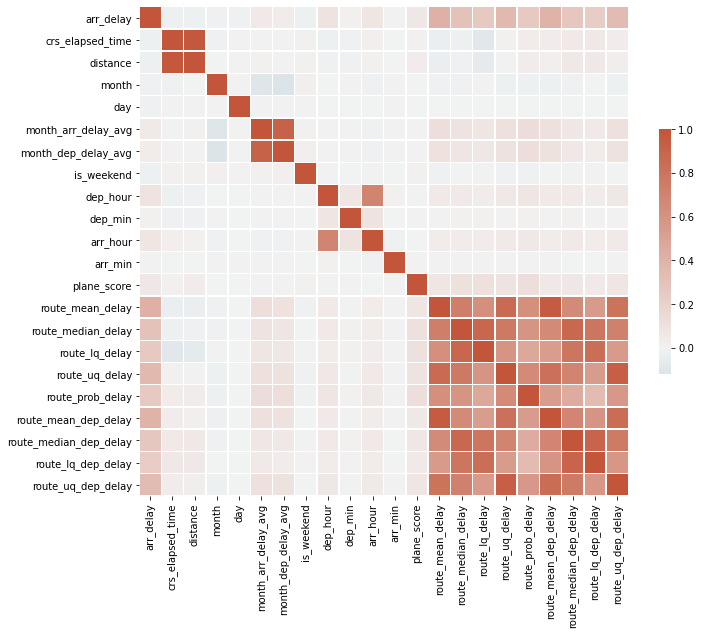

In [634]:
corr = flights_df1.corr(method='pearson')

fig, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [656]:
flights_df1 = flights_df1.drop(['crs_elapsed_time', 'distance', 'month', 'day', 'is_weekend', 'tail_num', 'origin', 'dest',
                               'op_unique_carrier'], axis=1)

In [657]:
X = flights_df1.drop('arr_delay', axis=1)
y = flights_df1['arr_delay']

In [671]:
X.columns

Index(['month_arr_delay_avg', 'month_dep_delay_avg', 'dep_hour', 'dep_min',
       'arr_hour', 'arr_min', 'plane_score', 'route_mean_delay',
       'route_median_delay', 'route_lq_delay', 'route_uq_delay',
       'route_prob_delay', 'route_mean_dep_delay', 'route_median_dep_delay',
       'route_lq_dep_delay', 'route_uq_dep_delay'],
      dtype='object')

In [639]:
tail_num_le = LabelEncoder()
X['tail_num'] = tail_num_le.fit_transform(X['tail_num'])

airports_le = LabelEncoder()
X['origin'] = airports_le.fit_transform(X['origin'])
X['dest'] = airports_le.fit_transform(X['dest'])

op_carrier_le = LabelEncoder()
X['op_unique_carrier'] = op_carrier_le.fit_transform(X['op_unique_carrier'])

In [640]:
dummies = pd.get_dummies(X[['dep_time_desc', 'arr_time_desc', 'orr_busy', 'arr_busy']])
X = pd.concat([X, dummies], axis=1)

In [658]:
X.drop(['dep_time_desc', 'arr_time_desc', 'orr_busy', 'arr_busy'], axis=1, inplace=True)

In [659]:
len(X.columns)

16

In [497]:
X

,op_unique_carrier,tail_num,origin,dest,crs_elapsed_time,distance,month,day,month_arr_delay_avg,month_dep_delay_avg,...,arr_time_desc_morning,arr_time_desc_noon,orr_busy_high,orr_busy_low,orr_busy_medium,orr_busy_medium-high,arr_busy_high,arr_busy_low,arr_busy_medium,arr_busy_medium-high
0,22,4062,119,127,192.0,1065,3,31,-6.0,-2.0,...,0,0,0,0,0,1,0,0,0,1
1,22,1905,119,127,183.0,1065,3,7,-6.0,-2.0,...,0,0,0,0,0,1,0,0,0,1
2,22,3639,119,127,192.0,1065,3,2,-6.0,-2.0,...,0,0,0,0,0,1,0,0,0,1
3,22,3639,119,127,195.0,1065,3,20,-6.0,-2.0,...,0,1,0,0,0,1,0,0,0,1
4,22,2045,119,127,187.0,1065,3,11,-6.0,-2.0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980253,12,92,194,25,163.0,1090,1,11,-7.0,-3.0,...,0,0,0,0,0,1,0,0,1,0
980254,12,92,194,113,95.0,583,1,29,-7.0,-3.0,...,0,0,0,0,0,1,0,0,1,0
980255,11,1823,94,362,165.0,1162,12,31,-6.0,-2.0,...,0,1,1,0,0,0,0,0,1,0
980256,26,1067,185,74,144.0,541,12,22,-6.0,-2.0,...,0,0,0,0,0,1,1,0,0,0


In [660]:
X_transformed = X.to_numpy()
y_transformed = y.to_numpy().reshape(-1,1)

In [38]:
'''
number_of_rows = X_transformed.shape[0]
random_indices = np.random.choice(number_of_rows, size=100000, replace=False)
X_transformed_sample = X_transformed[random_indices, :]

number_of_rows = y.shape[0]
y_sample = y[random_indices]

X_transformed_sample.shape, y_sample.shape
'''

'\nnumber_of_rows = X_transformed.shape[0]\nrandom_indices = np.random.choice(number_of_rows, size=100000, replace=False)\nX_transformed_sample = X_transformed[random_indices, :]\n\nnumber_of_rows = y.shape[0]\ny_sample = y[random_indices]\n\nX_transformed_sample.shape, y_sample.shape\n'

In [661]:
X_transformed

array([[-6., -2., 17., ..., -1., -6., 15.],
       [-6., -2., 19., ..., -1., -6., 15.],
       [-6., -2., 14., ..., -1., -6., 15.],
       ...,
       [-6., -2.,  7., ..., -5., -5., -5.],
       [-6., -2., 14., ..., -2., -2., -2.],
       [-6., -2.,  9., ..., 49., 49., 49.]])

In [662]:
xtrain, xtest, ytrain, ytest = train_test_split(X_transformed, y_transformed, test_size=0.2)

In [663]:
import xgboost as xgb

In [664]:
xg_reg = xgb.XGBRegressor()

xg_reg.fit(xtrain, ytrain)
xg_reg.score(xtest, ytest)

0.09284653092459838

In [43]:
rfr = RandomForestRegressor()

In [44]:
rfr.fit(xtrain, ytrain)

RandomForestRegressor()

In [45]:
rfr.score(xtest, ytest)

0.08131659693030946

In [46]:
def plot_feature_importance(importance,names,model_type):

#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

#Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
    plt.figure(figsize=(10,8))
#Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

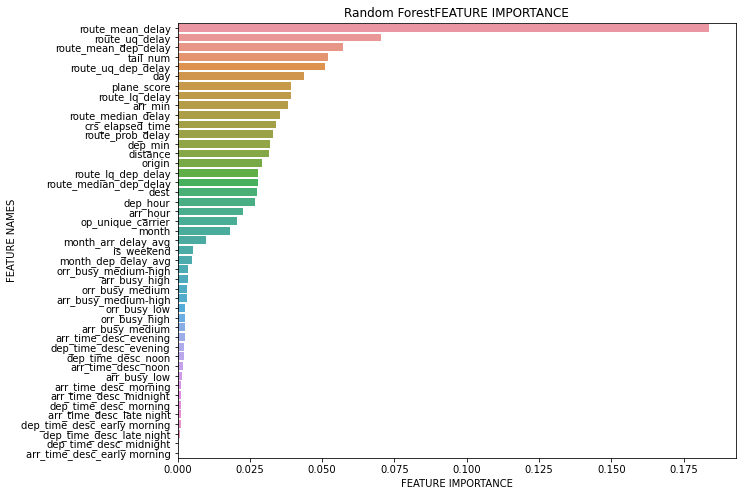

In [47]:
plot_feature_importance(rfr.feature_importances_, X.columns, 'Random Forest')

In [48]:
len(rfr.feature_importances_)

45

In [49]:
X.columns

Index(['op_unique_carrier', 'tail_num', 'origin', 'dest', 'crs_elapsed_time',
       'distance', 'month', 'day', 'month_arr_delay_avg',
       'month_dep_delay_avg', 'is_weekend', 'dep_hour', 'dep_min', 'arr_hour',
       'arr_min', 'plane_score', 'route_mean_delay', 'route_median_delay',
       'route_lq_delay', 'route_uq_delay', 'route_prob_delay',
       'route_mean_dep_delay', 'route_median_dep_delay', 'route_lq_dep_delay',
       'route_uq_dep_delay', 'dep_time_desc_early morning',
       'dep_time_desc_evening', 'dep_time_desc_late night',
       'dep_time_desc_midnight', 'dep_time_desc_morning', 'dep_time_desc_noon',
       'arr_time_desc_early morning', 'arr_time_desc_evening',
       'arr_time_desc_late night', 'arr_time_desc_midnight',
       'arr_time_desc_morning', 'arr_time_desc_noon', 'orr_busy_high',
       'orr_busy_low', 'orr_busy_medium', 'orr_busy_medium-high',
       'arr_busy_high', 'arr_busy_low', 'arr_busy_medium',
       'arr_busy_medium-high'],
      dtype='obj

In [665]:
gbr = GradientBoostingRegressor()

In [666]:
gbr.fit(xtrain, ytrain)

GradientBoostingRegressor()

In [668]:
gbr.score(xtest, ytest)

0.17244514943177136

In [669]:
y_pred = gbr.predict(xtest)

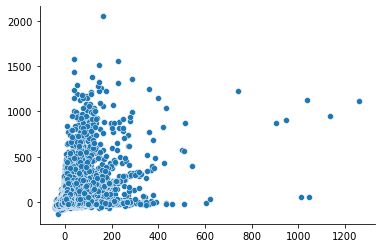

In [670]:
sns.scatterplot(x=y_pred, y=ytest.reshape(1,-1)[0])
sns.despine()
plt.show()

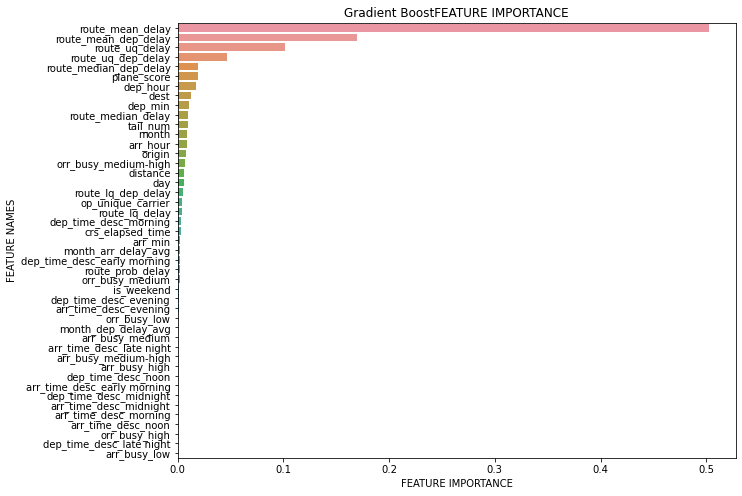

In [55]:
plot_feature_importance(gbr.feature_importances_, X.columns, 'Gradient Boost')

## Test 2: Only Flights Data - Drop a few features!

In [56]:
flights_df2 = flights[['route_mean_delay', 'route_mean_dep_delay', 'plane_score', 'route_median_delay', 'crs_elapsed_time',
                      'route_lq_delay', 'arr_hour', 'route_uq_delay', 'tail_num', 'dep_min', 'dep_hour', 'origin', 'route_prob_delay',
                      'dest', 'arr_min', 'arr_delay']]

In [57]:
flights_df2 = flights_df2.sample(frac=1)[:100000]

In [58]:
X = flights_df2.drop('arr_delay', axis=1)
y = flights_df2['arr_delay']

In [59]:
tail_num_le = LabelEncoder()
X['tail_num'] = tail_num_le.fit_transform(X['tail_num'])

airports_le = LabelEncoder()
X['origin'] = airports_le.fit_transform(X['origin'])
X['dest'] = airports_le.fit_transform(X['dest'])

In [60]:
X_transformed = X.to_numpy()
y_transformed = y.to_numpy().reshape(-1,1)

In [61]:
xtrain, xtest, ytrain, ytest = train_test_split(X_transformed, y_transformed, test_size=0.2)

In [62]:
gbr = GradientBoostingRegressor()

In [63]:
gbr.fit(xtrain, ytrain)
gbr.score(xtest, ytest)

0.16026965810020377

## Test 3: Incorporating Weather Data

In [692]:
flights_df3 = pd.merge(flights, weather, on=['date','origin', 'dest'], how='inner')

In [681]:
flights_df3.shape

(102479, 73)

In [682]:
flights_df3 = flights_df3.drop_duplicates()

In [683]:
flights_df3.shape

(102263, 73)

In [693]:
flights_df3 = flights_df3[[ 'arr_delay_x', 'month_arr_delay_avg', 'month_dep_delay_avg','dep_hour', 'dep_min', 'arr_hour', 'arr_min',
                          'plane_score', 'route_mean_delay', 'route_median_delay', 'route_lq_delay', 'route_uq_delay',
                          'route_prob_delay','route_mean_dep_delay', 'route_median_dep_delay', 'route_lq_dep_delay',
                           'route_uq_dep_delay','dep_avg_temp','dep_precip_mm', 'dep_humidity', 'dep_visibility', 'dep_total_snowcm','dep_windspeed', 'arr_avg_temp',
                            'arr_precip_mm', 'arr_humidity', 'arr_visibility', 'arr_total_snowcm','arr_windspeed']]

In [550]:
flights_df3 = flights_df3[['op_unique_carrier', 'tail_num', 'origin', 'dest', 'arr_delay_x', 'crs_elapsed_time',
                          'distance', 'month', 'day', 'month_arr_delay_avg', 'month_dep_delay_avg', 'is_weekend',
                          'dep_hour', 'dep_min', 'arr_hour', 'arr_min', 'dep_time_desc', 'arr_time_desc',
                          'plane_score', 'orr_busy', 'arr_busy', 'route_mean_delay', 'route_median_delay', 'route_lq_delay', 'route_uq_delay',
                          'route_prob_delay','route_mean_dep_delay', 'route_median_dep_delay', 'route_lq_dep_delay',
                           'route_uq_dep_delay','dep_avg_temp',
                           'dep_precip_mm', 'dep_humidity', 'dep_visibility', 'dep_total_snowcm',
                           'dep_windspeed', 'arr_avg_temp',
                            'arr_precip_mm', 'arr_humidity', 'arr_visibility', 'arr_total_snowcm',
                           'arr_windspeed']]

In [694]:
flights_df3.rename(columns={'arr_delay_x': 'arr_delay'}, inplace=True)

In [695]:
flights_df3.head()

,arr_delay,month_arr_delay_avg,month_dep_delay_avg,dep_hour,dep_min,arr_hour,arr_min,plane_score,route_mean_delay,route_median_delay,...,dep_humidity,dep_visibility,dep_total_snowcm,dep_windspeed,arr_avg_temp,arr_precip_mm,arr_humidity,arr_visibility,arr_total_snowcm,arr_windspeed
0,-19.0,-6.0,-2.0,6,45,12,44,-7.0,1.941176,-11.0,...,57,10,0.0,13,24,0.0,48,10,0.0,5
1,-12.0,-6.0,-2.0,6,35,12,35,-5.0,1.941176,-11.0,...,73,9,0.0,13,24,0.0,63,10,0.0,12
2,-12.0,-6.0,-2.0,11,15,17,12,-7.0,1.941176,-11.0,...,54,10,0.0,9,26,0.0,49,10,0.0,4
3,-12.0,-6.0,-2.0,11,15,17,12,-7.0,1.941176,-11.0,...,54,10,0.0,9,26,0.0,49,10,0.0,4
4,-16.0,-6.0,-2.0,6,45,12,44,-6.0,1.941176,-11.0,...,54,10,0.0,9,26,0.0,49,10,0.0,4


In [528]:
#flights_df3 = flights_df3.sample(frac=1)

In [696]:
X = flights_df3.drop('arr_delay', axis=1)
y = flights_df3['arr_delay']

In [554]:
tail_num_le = LabelEncoder()
X['tail_num'] = tail_num_le.fit_transform(X['tail_num'])

airports_le = LabelEncoder()
X['origin'] = airports_le.fit_transform(X['origin'])
X['dest'] = airports_le.fit_transform(X['dest'])

op_carrier_le = LabelEncoder()
X['op_unique_carrier'] = op_carrier_le.fit_transform(X['op_unique_carrier'])

In [555]:
dummies = pd.get_dummies(X[['dep_time_desc', 'arr_time_desc', 'orr_busy', 'arr_busy']])
X = pd.concat([X, dummies], axis=1)

In [556]:
X.drop(['dep_time_desc', 'arr_time_desc', 'orr_busy', 'arr_busy'], axis=1, inplace=True)

In [697]:
X_transformed = X.to_numpy()

In [558]:
X_transformed

array([[1.500e+01, 2.634e+03, 8.000e+00, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [1.500e+01, 3.199e+03, 8.000e+00, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [1.500e+01, 2.633e+03, 8.000e+00, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [7.000e+00, 2.023e+03, 1.000e+00, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [1.000e+01, 7.630e+02, 7.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [7.000e+00, 1.970e+03, 6.000e+00, ..., 1.000e+00, 1.000e+00,
        0.000e+00]])

In [698]:
y_transformed = y.to_numpy().reshape(-1,1)

In [699]:
xtrain, xtest, ytrain, ytest = train_test_split(X_transformed, y_transformed, test_size=0.2)

In [700]:
xgb_r = xgb.XGBRegressor()
xgb_r.fit(xtrain,ytrain)
xgb_r.score(xtest, ytest)

0.46887889424962625

In [701]:
y_pred_xgb = xgb_r.predict(xtest)

<AxesSubplot:>

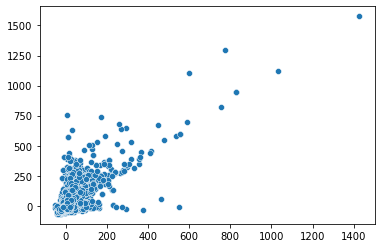

In [702]:
sns.scatterplot(x=y_pred_xgb, y=ytest.reshape(1,-1)[0])

In [565]:
gbr = GradientBoostingRegressor()

In [566]:
gbr.fit(xtrain, ytrain)
gbr.score(xtest, ytest)

0.1395435363223143

In [567]:
y_pred_weather = gbr.predict(xtest)

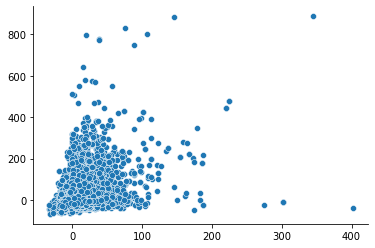

In [568]:
sns.scatterplot(x=y_pred_weather, y=ytest.reshape(1,-1)[0])
sns.despine()
plt.show()

## Test 4: Split the Dataset into Extreme Delay, Medium, and Non-Extreme Delay; No Weather Data

In [703]:
 flights_df4 = flights[['arr_delay', 'month_arr_delay_avg','month_dep_delay_avg', 'dep_hour', 'dep_min', 'arr_hour',
       'arr_min',  'plane_score', 'route_mean_delay', 'route_median_delay', 'route_lq_delay',
       'route_uq_delay', 'route_prob_delay', 'route_mean_dep_delay','orr_busy',
       'arr_busy','route_median_dep_delay', 'route_lq_dep_delay', 'route_uq_dep_delay', 'dep_time_desc', 'arr_time_desc']]

In [403]:
flights_df4 = flights[['op_unique_carrier', 'tail_num', 'origin', 'dest', 'arr_delay',
       'crs_elapsed_time', 'distance', 'month', 'day', 'month_arr_delay_avg',
       'month_dep_delay_avg', 'is_weekend', 'dep_hour', 'dep_min', 'arr_hour',
       'arr_min', 'dep_time_desc', 'arr_time_desc', 'plane_score', 'orr_busy',
       'arr_busy', 'route_mean_delay', 'route_median_delay', 'route_lq_delay',
       'route_uq_delay', 'route_prob_delay', 'route_mean_dep_delay',
       'route_median_dep_delay', 'route_lq_dep_delay', 'route_uq_dep_delay']]

#Make a model with less features --> that are correlated with each other --> tail_num --> take 10 features and train
#Take the top 10 --> might lost from month, day, narrow it down --> try to find those that are linearly correlated - might help


In [704]:
extreme_delays = flights_df4[flights_df4['arr_delay'] >= 240]
extreme_delays.shape

(5876, 17)

In [705]:
nonext_delays = flights_df4[flights_df4['arr_delay'] < 60]
nonext_delays.shape

(914909, 17)

In [706]:
medium_delays = flights_df4[(flights_df4['arr_delay'] >= 60) & (flights_df4['arr_delay'] <= 240)]
medium_delays.shape

(59528, 17)

In [407]:
#nonext_delays = nonext_delays.sample(frac=1)[:100000]
#nonext_delays.shape

(100000, 30)

<b> Make model for extreme delays! </b>

In [707]:
extreme_delays.head()

,arr_delay,month_arr_delay_avg,month_dep_delay_avg,dep_hour,dep_min,arr_hour,arr_min,plane_score,route_mean_delay,route_median_delay,route_lq_delay,route_uq_delay,route_prob_delay,route_mean_dep_delay,route_median_dep_delay,route_lq_dep_delay,route_uq_dep_delay
88,299.0,-6.0,-2.0,10,25,12,22,-5.0,9.733333,-13.0,-15.5,-4.0,0.066667,16.133333,-4.0,-7.0,-1.5
107,325.0,-6.0,-2.0,7,59,11,25,-3.0,37.176471,-6.0,-18.0,35.0,0.352941,41.235294,1.0,-4.0,27.0
108,299.0,-6.0,-2.0,19,30,23,6,-3.0,37.176471,-6.0,-18.0,35.0,0.352941,41.235294,1.0,-4.0,27.0
147,295.0,-6.0,-2.0,16,35,19,28,-6.0,4.024390,-9.0,-23.0,11.0,0.268293,16.121951,-3.0,-5.0,18.0
186,335.0,-6.0,-2.0,5,3,9,9,-8.0,30.111111,-10.0,-18.0,-7.0,0.222222,35.777778,-4.0,-8.0,-1.0


In [708]:
X_ext = extreme_delays.drop('arr_delay', axis=1)
y_ext = extreme_delays['arr_delay']

In [410]:
tail_num_le = LabelEncoder()
X_ext['tail_num'] = tail_num_le.fit_transform(X_ext['tail_num'])

airports_le = LabelEncoder()
X_ext['origin'] = airports_le.fit_transform(X_ext['origin'])
X_ext['dest'] = airports_le.fit_transform(X_ext['dest'])

op_carrier_le = LabelEncoder()
X_ext['op_unique_carrier'] = op_carrier_le.fit_transform(X_ext['op_unique_carrier'])

In [411]:
dummies = pd.get_dummies(X_ext[['dep_time_desc', 'arr_time_desc', 'orr_busy', 'arr_busy']])
X_ext = pd.concat([X_ext, dummies], axis=1)

In [412]:
X_ext.drop(['dep_time_desc', 'arr_time_desc', 'orr_busy', 'arr_busy'], axis=1, inplace=True)

In [709]:
X_ext_transformed = X_ext.to_numpy()

In [710]:
y_ext_transformed = y_ext.to_numpy().reshape(-1,1)

In [711]:
X_train, X_test, y_train, y_test = train_test_split(X_ext_transformed, y_ext_transformed, train_size=0.75)

In [416]:
# Gradient Boost
gbr = GradientBoostingRegressor()

In [417]:
gbr.fit(X_train, y_train)
gbr.score(X_test, y_test)

0.6663623359627828

In [418]:
y_pred_ext = gbr.predict(X_test)

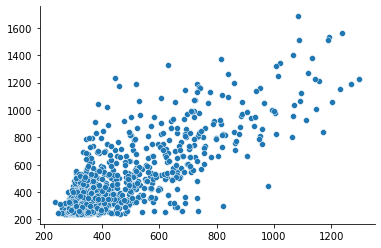

In [419]:
sns.scatterplot(x=y_pred_ext, y=y_test.reshape(1,-1)[0])
sns.despine()
plt.show()

In [712]:
# XGBoost
xgb = xgb.XGBRegressor()

In [713]:
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.6450599946591722

In [714]:
y_pred_ext_xgb = xgb.predict(X_test)

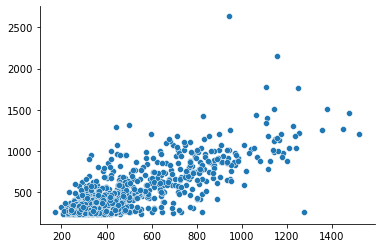

In [716]:
sns.scatterplot(x=y_pred_ext_xgb, y=y_test.reshape(1,-1)[0])
sns.despine()
plt.show()

In [427]:
#Random Forest 
rfr = RandomForestRegressor()

In [428]:
rfr.fit(X_train, y_train)
rfr.score(X_test, y_test)

0.6641657216070656

In [429]:
y_pred_ext_rfr = rfr.predict(X_test)

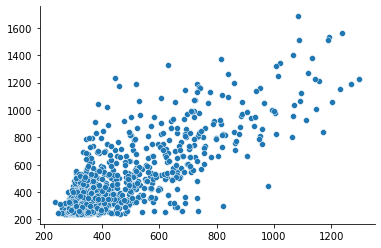

In [430]:
sns.scatterplot(x=y_pred_ext, y=y_test.reshape(1,-1)[0])
sns.despine()
plt.show()

<b> Modelling non-extreme delays! </b>

In [717]:
nonext_delays.shape

(914909, 17)

In [718]:
X_nonext = nonext_delays.drop('arr_delay', axis=1)
y_nonext = nonext_delays['arr_delay']

In [437]:
tail_num_le = LabelEncoder()
X_nonext['tail_num'] = tail_num_le.fit_transform(X_nonext['tail_num'])

airports_le = LabelEncoder()
X_nonext['origin'] = airports_le.fit_transform(X_nonext['origin'])
X_nonext['dest'] = airports_le.fit_transform(X_nonext['dest'])

op_carrier_le = LabelEncoder()
X_nonext['op_unique_carrier'] = op_carrier_le.fit_transform(X_nonext['op_unique_carrier'])

In [438]:
dummies = pd.get_dummies(X_nonext[['dep_time_desc', 'arr_time_desc', 'orr_busy', 'arr_busy']])
X_nonext = pd.concat([X_nonext, dummies], axis=1)

In [439]:
X_nonext.drop(['dep_time_desc', 'arr_time_desc', 'orr_busy', 'arr_busy'], axis=1, inplace=True)

In [719]:
X_nonext_transformed = X_nonext.to_numpy()

In [720]:
y_nonext_transformed = y_nonext.to_numpy().reshape(-1,1)

In [721]:
X_train, X_test, y_train, y_test = train_test_split(X_nonext_transformed, y_nonext_transformed, train_size=0.75)

In [443]:
#Gradient Boost Regressor
gbr = GradientBoostingRegressor()

In [444]:
gbr.fit(X_train, y_train)
gbr.score(X_test, y_test)

0.19173311498549495

In [445]:
y_pred_nonext = gbr.predict(X_test)

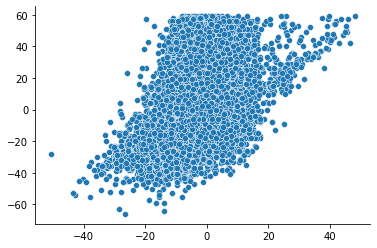

In [446]:
sns.scatterplot(x=y_pred_nonext, y=y_test.reshape(1,-1)[0])
sns.despine()
plt.show()

In [447]:
#Random Forest Regressor

rfr = RandomForestRegressor()

In [448]:
rfr.fit(X_train, y_train)
rfr.score(X_test, y_test)

0.14392345159656983

In [449]:
y_pred_nonext = rfr.predict(X_test)

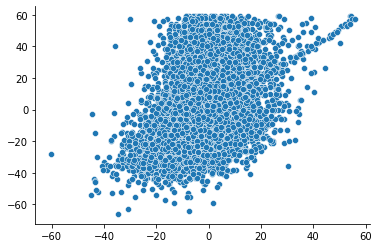

In [450]:
sns.scatterplot(x=y_pred_nonext, y=y_test.reshape(1,-1)[0])
sns.despine()
plt.show()

In [724]:
xgb_r = xgb.XGBRegressor()
xgb_r.fit(X_train, y_train)
xgb_r.score(X_test, y_test)

0.18518783636871872

In [725]:
y_pred_xgb_noext = xgb_r.predict(X_test)

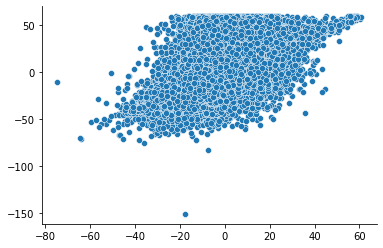

In [726]:
sns.scatterplot(x=y_pred_xgb_noext, y=y_test.reshape(1,-1)[0])
sns.despine()
plt.show()

In [ ]:
#XGBoost hyperparameter tuning: a bunch of knobs, slowly inching the knobs and see 

<b> Make separate model for medium delays! </b>

In [727]:
medium_delays.head()

,arr_delay,month_arr_delay_avg,month_dep_delay_avg,dep_hour,dep_min,arr_hour,arr_min,plane_score,route_mean_delay,route_median_delay,route_lq_delay,route_uq_delay,route_prob_delay,route_mean_dep_delay,route_median_dep_delay,route_lq_dep_delay,route_uq_dep_delay
6,118.0,-6.0,-2.0,14,5,17,8,-1.0,0.240000,-11.0,-18.0,4.00,0.200000,12.720000,-1.0,-6.00,15.00
16,77.0,-6.0,-2.0,18,31,21,40,-6.0,0.240000,-11.0,-18.0,4.00,0.200000,12.720000,-1.0,-6.00,15.00
27,84.0,-6.0,-2.0,19,10,20,53,-6.0,24.250000,23.0,-25.5,72.75,0.500000,40.000000,38.0,-4.75,82.75
28,69.0,-6.0,-2.0,19,10,20,53,-4.0,24.250000,23.0,-25.5,72.75,0.500000,40.000000,38.0,-4.75,82.75
33,81.0,-6.0,-2.0,10,45,18,20,-7.0,2.318182,-13.5,-23.0,23.00,0.363636,13.363636,0.0,-5.00,33.25


In [728]:
X_medium = medium_delays.drop('arr_delay', axis=1)
y_medium = medium_delays['arr_delay']

In [460]:
tail_num_le = LabelEncoder()
X_medium['tail_num'] = tail_num_le.fit_transform(X_medium['tail_num'])

airports_le = LabelEncoder()
X_medium['origin'] = airports_le.fit_transform(X_medium['origin'])
X_medium['dest'] = airports_le.fit_transform(X_medium['dest'])

op_carrier_le = LabelEncoder()
X_medium['op_unique_carrier'] = op_carrier_le.fit_transform(X_medium['op_unique_carrier'])

In [461]:
dummies = pd.get_dummies(X_medium[['dep_time_desc', 'arr_time_desc', 'orr_busy', 'arr_busy']])
X_medium = pd.concat([X_medium, dummies], axis=1)

In [462]:
X_medium.drop(['dep_time_desc', 'arr_time_desc', 'orr_busy', 'arr_busy'], axis=1, inplace=True)

In [729]:
X_medium_transformed = X_medium.to_numpy()

In [730]:
y_medium_transformed = y_medium.to_numpy().reshape(-1,1)

In [731]:
X_train, X_test, y_train, y_test = train_test_split(X_medium_transformed, y_medium_transformed, train_size=0.75)

In [466]:
# GBR
gbr = GradientBoostingRegressor()

In [467]:
gbr.fit(X_train, y_train)
gbr.score(X_test, y_test)

0.3302531943810929

In [468]:
y_pred_medium = gbr.predict(X_test)

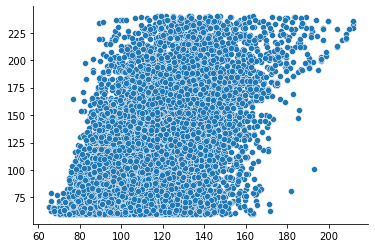

In [469]:
sns.scatterplot(x=y_pred_medium, y=y_test.reshape(1,-1)[0])
sns.despine()
plt.show()

In [471]:
# RFR

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
rfr.score(X_test, y_test)

0.264691879312389

In [472]:
y_pred_medium_rfr = rfr.predict(X_test)

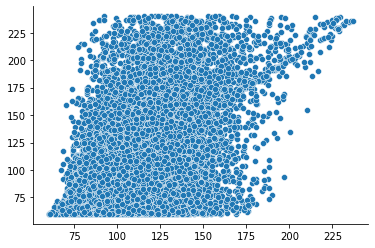

In [473]:
sns.scatterplot(x=y_pred_medium_rfr, y=y_test.reshape(1,-1)[0])
sns.despine()
plt.show()

In [732]:
# XGB

xgb_r = xgb.XGBRegressor()

In [733]:
xgb_r.fit(X_train, y_train)
xgb_r.score(X_test, y_test)

0.3375583137918

In [734]:
y_pred_medium_xgb = xgb_r.predict(X_test)

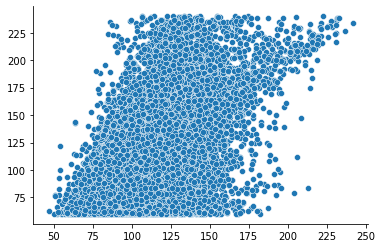

In [735]:
sns.scatterplot(x=y_pred_medium_xgb, y=y_test.reshape(1,-1)[0])
sns.despine()
plt.show()

## Test 5: Split the Dataset into Extreme Delay and Non-Extreme Delay; Weather Data

In [578]:
weather = pd.read_csv('../data/complete_weather_df.csv')

In [579]:
weather['weather_description'].unique()

array(['Partly cloudy', 'Overcast', 'Sunny', 'Moderate rain',
       'Ice pellets', 'Cloudy', 'Blizzard', 'Blowing snow',
       'Patchy heavy snow', 'Patchy rain possible',
       'Moderate or heavy freezing rain', 'Light snow', 'Light drizzle',
       'Light rain shower', 'Torrential rain shower',
       'Thundery outbreaks possible', 'Patchy light drizzle',
       'Patchy light snow', 'Heavy rain', 'Moderate rain at times',
       'Patchy light rain with thunder', 'Mist', 'Heavy rain at times',
       'Moderate or heavy rain shower', 'Light rain', 'Light sleet',
       'Patchy light rain', 'Heavy snow',
       'Patchy freezing drizzle possible',
       'Moderate or heavy rain with thunder', 'Fog', 'Moderate snow',
       'Patchy moderate snow', 'Patchy snow possible',
       'Moderate or heavy sleet', 'Light snow showers',
       'Moderate or heavy snow showers', 'Light freezing rain',
       'Patchy light snow with thunder', 'Patchy sleet possible',
       'Light sleet showers', 'H

In [580]:
def is_extreme_weather(weather):
    if ('blizzard' in weather.lower()) or ('fog' in weather.lower()) or ('heavy sleet' in weather.lower()) or ('heavy rain' in weather.lower()) or ('mist' in weather.lower()) or ('ice pellets' in weather.lower()) or ('thunder' in weather.lower()) or ('overcast' in weather.lower()):
        return 1
    else:
        return 0

In [581]:
weather['is_extreme'] = weather['weather_description'].map(is_extreme_weather)

In [582]:
weather.drop(['weather_description', 'Unnamed: 0'], axis=1, inplace=True)

In [585]:
weather['iata_code'].unique()

array(['ATL', 'DCA', 'DFW', 'JFK', 'LAX', 'LGA', 'MSP', 'ORD', 'SEA',
       'BOS', 'DEN', 'CLT', 'SFO', 'IAH', 'PHX', 'LAS', 'MCO', 'PHL',
       'DTW'], dtype=object)

In [586]:
flights_df5 = flights[['date', 'op_unique_carrier', 'tail_num', 'origin', 'dest', 'arr_delay',
       'crs_elapsed_time', 'distance', 'month', 'day', 'month_arr_delay_avg',
       'month_dep_delay_avg', 'is_weekend', 'dep_hour', 'dep_min', 'arr_hour',
       'arr_min', 'dep_time_desc', 'arr_time_desc', 'plane_score', 'orr_busy',
       'arr_busy', 'route_mean_delay', 'route_median_delay', 'route_lq_delay',
       'route_uq_delay', 'route_prob_delay', 'route_mean_dep_delay',
       'route_median_dep_delay', 'route_lq_dep_delay', 'route_uq_dep_delay']]

In [587]:
flights_df5.shape

(980258, 31)

In [588]:
weather_origin = weather.rename(columns={'iata_code': 'origin'})
weather_dest = weather.rename(columns={'iata_code': 'dest'})

In [589]:
flights_df5 = pd.merge(flights_df5, weather_origin, on=['date', 'origin'], how='inner')
flights_df5 = pd.merge(flights_df5, weather_dest, on=['date', 'dest'], how='inner')

In [590]:
flights_df5.columns

Index(['date', 'op_unique_carrier', 'tail_num', 'origin', 'dest', 'arr_delay',
       'crs_elapsed_time', 'distance', 'month', 'day', 'month_arr_delay_avg',
       'month_dep_delay_avg', 'is_weekend', 'dep_hour', 'dep_min', 'arr_hour',
       'arr_min', 'dep_time_desc', 'arr_time_desc', 'plane_score', 'orr_busy',
       'arr_busy', 'route_mean_delay', 'route_median_delay', 'route_lq_delay',
       'route_uq_delay', 'route_prob_delay', 'route_mean_dep_delay',
       'route_median_dep_delay', 'route_lq_dep_delay', 'route_uq_dep_delay',
       'avg_temp_x', 'precip_mm_x', 'humidity_x', 'visibility_x',
       'windspeed_kmhr_x', 'total_snowcm_x', 'is_extreme_x', 'avg_temp_y',
       'precip_mm_y', 'humidity_y', 'visibility_y', 'windspeed_kmhr_y',
       'total_snowcm_y', 'is_extreme_y'],
      dtype='object')

In [591]:
colnames = {'avg_temp_x':'dep_avg_temp', 'precip_mm_x': 'dep_precip', 'humidity_x':'dep_humidity',
           'visibility_x':'dep_visibility', 'windspeed_kmhr_x': 'dep_windspeed', 'total_snowcm_x':'dep_totalsnow',
           'is_extreme_x': 'dep_is_extreme', 'avg_temp_y':'arr_avg_temp', 'precip_mm_y':'arr_precip','humidity_y':'arr_humidity',
           'visibility_y':'arr_visibility', 'windspeed_kmhr_y':'arr_windspeed', 'total_snowcm_y':'arr_totalsnow', 
           'is_extreme_y': 'arr_is_extreme'}

flights_df5.rename(columns=colnames, inplace=True)

In [592]:
flights_df5.columns

Index(['date', 'op_unique_carrier', 'tail_num', 'origin', 'dest', 'arr_delay',
       'crs_elapsed_time', 'distance', 'month', 'day', 'month_arr_delay_avg',
       'month_dep_delay_avg', 'is_weekend', 'dep_hour', 'dep_min', 'arr_hour',
       'arr_min', 'dep_time_desc', 'arr_time_desc', 'plane_score', 'orr_busy',
       'arr_busy', 'route_mean_delay', 'route_median_delay', 'route_lq_delay',
       'route_uq_delay', 'route_prob_delay', 'route_mean_dep_delay',
       'route_median_dep_delay', 'route_lq_dep_delay', 'route_uq_dep_delay',
       'dep_avg_temp', 'dep_precip', 'dep_humidity', 'dep_visibility',
       'dep_windspeed', 'dep_totalsnow', 'dep_is_extreme', 'arr_avg_temp',
       'arr_precip', 'arr_humidity', 'arr_visibility', 'arr_windspeed',
       'arr_totalsnow', 'arr_is_extreme'],
      dtype='object')

In [593]:
flights_df5.drop(['date'], axis=1, inplace=True)

In [594]:
ext_delay_weather = flights_df5[flights_df5['arr_delay'] >= 240]
ext_delay_weather.shape

(1139, 44)

In [595]:
nonext_delay_weather = flights_df5[flights_df5['arr_delay'] < 240]
nonext_delay_weather.shape

(180661, 44)

### Extreme Weather

In [596]:
X_ext_weather = ext_delay_weather.drop('arr_delay', axis=1)
y_ext_weather = ext_delay_weather['arr_delay']

In [597]:
tail_num_le = LabelEncoder()
X_ext_weather['tail_num'] = tail_num_le.fit_transform(X_ext_weather['tail_num'])

airports_le = LabelEncoder()
X_ext_weather['origin'] = airports_le.fit_transform(X_ext_weather['origin'])
X_ext_weather['dest'] = airports_le.fit_transform(X_ext_weather['dest'])

op_carrier_le = LabelEncoder()
X_ext_weather['op_unique_carrier'] = op_carrier_le.fit_transform(X_ext_weather['op_unique_carrier'])

In [598]:
dummies = pd.get_dummies(X_ext_weather[['dep_time_desc', 'arr_time_desc', 'orr_busy', 'arr_busy']])
X_ext_weather = pd.concat([X_ext_weather, dummies], axis=1)

In [599]:
X_ext_weather.drop(['dep_time_desc', 'arr_time_desc', 'orr_busy', 'arr_busy'], axis=1, inplace=True)

In [600]:
X_ext_weather_transformed = X_ext_weather.to_numpy()

In [601]:
y_ext_weather_transformed = y_ext_weather.to_numpy().reshape(-1,1)

In [602]:
X_train, X_test, y_train, y_test = train_test_split(X_ext_weather_transformed, y_ext_weather_transformed, train_size=0.75)

In [603]:
xgb_r = xgb.XGBRegressor()

xgb_r.fit(X_train, y_train)
xgb_r.score(X_test, y_test)

0.42133672850228776

In [604]:
y_pred_ext_gbr = xgb_r.predict(X_test)

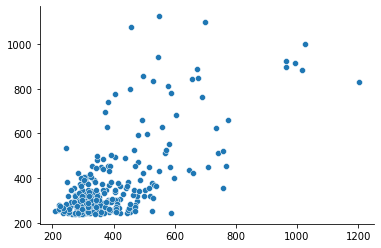

In [605]:
sns.scatterplot(x=y_pred_ext_gbr, y=y_test.reshape(1,-1)[0])
sns.despine()
plt.show()


In [399]:
gbr = GradientBoostingRegressor()

In [400]:
gbr.fit(X_train, y_train)
gbr.score(X_test, y_test)

0.40291383756227284

In [350]:
y_pred_ext_weather = gbr.predict(X_test)

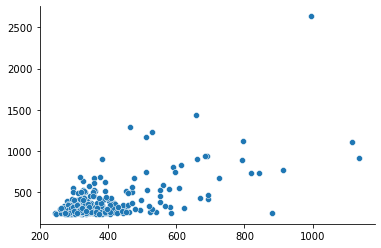

In [351]:
sns.scatterplot(x=y_pred_ext_weather, y=y_test.reshape(1,-1)[0])
sns.despine()
plt.show()

#subsets of columns and train on that -> better 

### Non-extreme Weather

In [614]:
X_nonext_weather = nonext_delay_weather.drop('arr_delay', axis=1)
y_nonext_weather = nonext_delay_weather['arr_delay']

In [615]:
tail_num_le = LabelEncoder()
X_nonext_weather['tail_num'] = tail_num_le.fit_transform(X_nonext_weather['tail_num'])

airports_le = LabelEncoder()
X_nonext_weather['origin'] = airports_le.fit_transform(X_nonext_weather['origin'])
X_nonext_weather['dest'] = airports_le.fit_transform(X_nonext_weather['dest'])

op_carrier_le = LabelEncoder()
X_nonext_weather['op_unique_carrier'] = op_carrier_le.fit_transform(X_nonext_weather['op_unique_carrier'])

In [616]:
dummies = pd.get_dummies(X_nonext_weather[['dep_time_desc', 'arr_time_desc', 'orr_busy', 'arr_busy']])
X_nonext_weather = pd.concat([X_nonext_weather, dummies], axis=1)

In [617]:
X_nonext_weather.drop(['dep_time_desc', 'arr_time_desc', 'orr_busy', 'arr_busy'], axis=1, inplace=True)

In [618]:
X_nonext_weather_transformed = X_nonext_weather.to_numpy()

In [619]:
y_nonext_weather_transformed = y_nonext_weather.to_numpy().reshape(-1,1)

In [620]:
X_train, X_test, y_train, y_test = train_test_split(X_nonext_weather_transformed, y_nonext_weather_transformed, train_size=0.75)

In [1]:
xgb_r = xgb.XGBRegressor()

xgb_r.fit(X_train, y_train)
xgb_r.predict(X_test, y_test)

In [359]:
gbr = GradientBoostingRegressor()

In [360]:
gbr.fit(X_train, y_train)
gbr.score(X_test, y_test)

0.15180268234531835

In [361]:
y_pred_nonext_weather = gbr.predict(X_test)

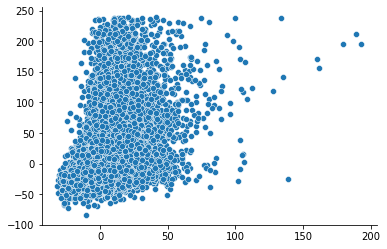

In [362]:
sns.scatterplot(x=y_pred_nonext_weather, y=y_test.reshape(1,-1)[0])
sns.despine()
plt.show()

# Test 4 appears to be the best approach!